In [2]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import torch as torch

In [3]:
@np.vectorize
def harmonic_potential(x, k=1):
    return 0.5 * k * x**2

def G(x, dG=4, delta_x=1):
    return dG * harmonic_potential(x / delta_x)

@nb.jit(nopython=True, fastmath=True)
#harmonic potential
def force(x, k):
    Fx = -k * x
    return Fx

def simulate_brownian_motion(num_steps=1000, dt = 5e-06, replica_num=1, D=10, x0=np.array([-1.5], dtype=np.float64), save_every=1, k = 3):
    num_steps = int(num_steps)
    save_every = int(save_every)
    
    N = num_steps

    diffusion_coeffs = np.full(replica_num, D)
    Ax = diffusion_coeffs * dt
    Bx = np.sqrt(2 * Ax)
    
    x = np.zeros((num_steps//save_every, replica_num, 1), dtype=np.float64)
    xold = np.tile(x0, (replica_num, 1))

    for i in range(1, N):
        # forces evaluation
        Fx = force(xold, k=k)

        # Drawing noise 
        gx = np.random.standard_normal(size=(replica_num, 1))

        # integration
        xnew = xold + Ax[:, None] * Fx + Bx[:, None] * gx

        if (i % save_every) == 0:
            x[i // save_every] = xnew

        xold = xnew

    return x

In [11]:
def simulate_brownian_motion(num_steps=100000,dt = 5e-06, replica_num=1, D=100, x0=np.array([-1.5], dtype=np.float64), save_every=1, k=3):
    num_steps = int(num_steps)
    save_every = int(save_every)
    
    N = num_steps

    diffusion_coeffs = np.full(replica_num, D)
    Ax = diffusion_coeffs * dt
    Bx = np.sqrt(2 * Ax)
    
    x = np.zeros((num_steps//save_every, replica_num, 1), dtype=np.float64)
    xold = np.tile(x0, (replica_num, 1))

    for i in range(1, N):
        # forces evaluation
        Fx = -k * xold

        # Drawing noise 
        gx = np.random.standard_normal(size=(replica_num, 1))

        # integration
        xnew = xold + Ax[:, None] * Fx + Bx[:, None] * gx

        if (i % save_every) == 0:
            x[i // save_every] = xnew

        xold = xnew

    return x

In [19]:
x = simulate_brownian_motion(num_steps=1000, dt = 5e-06, replica_num=1, D=100, x0=np.array([0], dtype=np.float64), save_every=1, k=3)

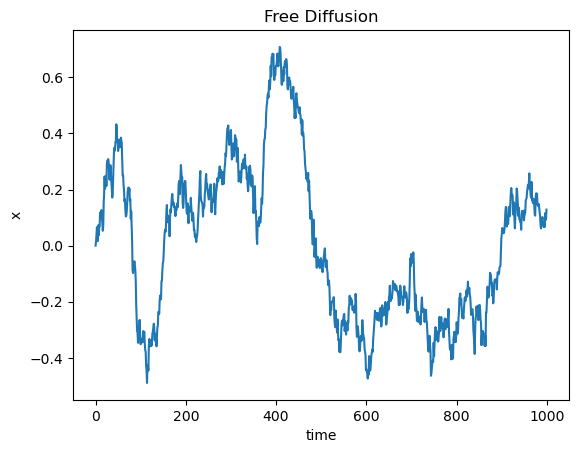

In [21]:
plt.plot(x[:, 0, 0])
plt.xlabel('time')
plt.ylabel('x')
plt.title('Free Diffusion')
plt.show()

/tmp/ipykernel_1552989/852427397.py:3: RuntimeWarning: divide by zero encountered in log
  pmf_sim = -np.log(counts)


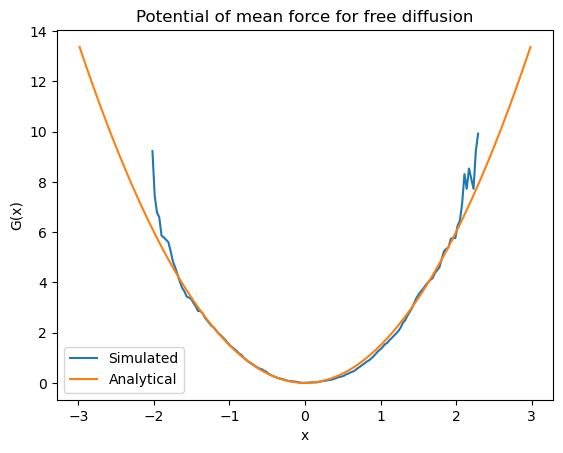

In [14]:
counts, edges = np.histogram(x, bins=np.linspace(-3, 3, 200), density=True)
centers = (edges[:-1] + edges[1:]) / 2
pmf_sim = -np.log(counts)
pmf_sim -= np.min(pmf_sim)
def G(x):
    return 3/2 * x**2

plt.plot(centers, pmf_sim, label='Simulated')
plt.plot(centers, G(centers) - min(G(centers)), label='Analytical')
plt.xlabel('x')
plt.ylabel('G(x)')
plt.title('Potential of mean force for free diffusion')
plt.legend()